In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [0]:
# import the necessary packages
from imutils import paths
import numpy as np
import imutils
import cv2
from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt

In [3]:
# grab the paths to the input images and initialize our images list
pathToImages = "/content/drive/My Drive/image-stitching-opencv/images"
print("Loading Images...")
imagePaths = sorted(list(paths.list_images(pathToImages)))
images = []

Loading Images...


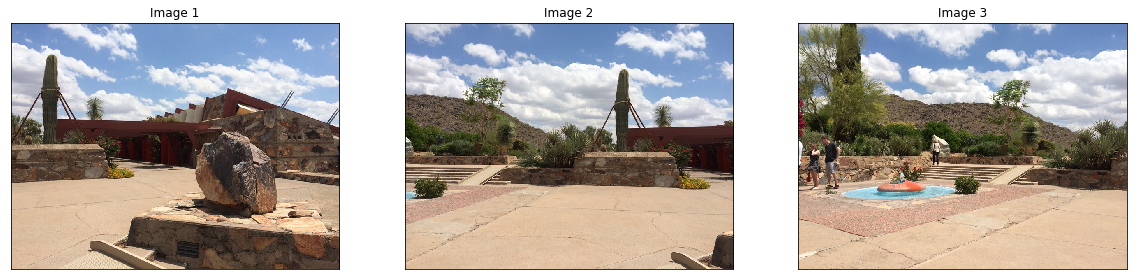

In [5]:
# loop over the image paths, load each one, and add them to our
# images to stich list
for imagePath in imagePaths:
	image = cv2.imread(imagePath)
	images.append(image)
 
titles = ['Image 1', 'Image 2', 'Image 3']
plt.figure(figsize=(20,20))
plt.subplot(1,3,1),plt.imshow(cv2.cvtColor(images[0], cv2.COLOR_BGR2RGB))
plt.title(titles[0]), plt.xticks([]), plt.yticks([])
plt.subplot(1,3,2),plt.imshow(cv2.cvtColor(images[1], cv2.COLOR_BGR2RGB))
plt.title(titles[1]), plt.xticks([]), plt.yticks([])
plt.subplot(1,3,3),plt.imshow(cv2.cvtColor(images[2], cv2.COLOR_BGR2RGB))
plt.title(titles[2]), plt.xticks([]), plt.yticks([])
plt.show()

In [0]:
class Stitcher:
  def __init__(self):
		# determine if we are using OpenCV v3.X
    self.isv3 = imutils.is_cv3(or_better=True)
  
  def trim(self, frame):
    if not np.sum(frame[0]):
      return self.trim(frame[1:])
    #crop top
    if not np.sum(frame[-1]):
      return self.trim(frame[:-2])
    #crop top
    if not np.sum(frame[:,0]):
      return self.trim(frame[:,1:])
    #crop top
    if not np.sum(frame[:,-1]):
      return self.trim(frame[:,:-2])
    return frame
  
  def stitch(self, images, ratio=0.75, reprojThresh=4.0, showMatches=False):
    # unpack the images, then detect keypoints and extract
    # local invariant descriptors from them
    (imageB, imageA) = images
    (kpsA, featuresA) = self.detectAndDescribe(imageA)
    (kpsB, featuresB) = self.detectAndDescribe(imageB)

    # match features between the two images
    matchedKeyPoints = self.matchKeypoints(kpsA, kpsB,
      featuresA, featuresB, ratio, reprojThresh)

    # if the match is None, then there aren't enough matched keypoints to create a panorama
    if matchedKeyPoints is None:
      return None

    # otherwise, apply a perspective warp to stitch the images
    # together
    (matches, H, status) = matchedKeyPoints
    result = cv2.warpPerspective(imageA, H, (imageA.shape[1] + imageB.shape[1], imageA.shape[0]))
    result[0:imageB.shape[0], 0:imageB.shape[1]] = imageB
    croppedResult = self.trim(result)

    # check to see if the keypoint matches should be visualized
    if showMatches:
      visualKeyPoints = self.drawMatches(imageA, imageB, kpsA, kpsB, matches,
        status)

      # return a tuple of the stitched image and the visualization
      return (croppedResult, visualKeyPoints)

    # return the stitched image
    return croppedResult
    
  def detectAndDescribe(self, image):
    # convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # check to see if we are using OpenCV 3.X
    if self.isv3:
      # detect and extract features from the image
      descriptor = cv2.xfeatures2d.SIFT_create()
      (kps, features) = descriptor.detectAndCompute(image, None)

    # otherwise, we are using OpenCV 2.4.X
    else:
      # detect keypoints in the image
      detector = cv2.FeatureDetector_create("SIFT")
      kps = detector.detect(gray)

      # extract features from the image
      extractor = cv2.DescriptorExtractor_create("SIFT")
      (kps, features) = extractor.compute(gray, kps)

    # convert the keypoints from KeyPoint objects to NumPy
    # arrays
    kps = np.float32([kp.pt for kp in kps])

    # return a tuple of keypoints and features
    return (kps, features)
  
  def matchKeypoints(self, kpsA, kpsB, featuresA, featuresB, ratio, reprojThresh):
    # compute the raw matches and initialize the list of actual matches
    matcher = cv2.DescriptorMatcher_create("BruteForce")
    rawMatches = matcher.knnMatch(featuresA, featuresB, 2)
    matches = []

    # loop over the raw matches
    for match in rawMatches:
      # ensure the distance is within a certain ratio of each
      # other (i.e. Lowe's ratio test)
      if len(match) == 2 and match[0].distance < match[1].distance * ratio:
        matches.append((match[0].trainIdx, match[0].queryIdx))

    # computing a homography requires at least 4 matches
    if len(matches) > 4:
      # construct the two sets of points
      ptsA = np.float32([kpsA[i] for (_, i) in matches])
      ptsB = np.float32([kpsB[i] for (i, _) in matches])

      # compute the homography between the two sets of points
      (H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC,
        reprojThresh)

      # return the matches along with the homograpy matrix
      # and status of each matched point
      return (matches, H, status)

    # otherwise, no homograpy could be computed
    return None
  
  def drawMatches(self, imageA, imageB, kpsA, kpsB, matches, status):
    # initialize the output visualization image
    (hA, wA) = imageA.shape[:2]
    (hB, wB) = imageB.shape[:2]
    visualImage = np.zeros((max(hA, hB), wA + wB, 3), dtype="uint8")
    visualImage[0:hA, 0:wA] = imageA
    visualImage[0:hB, wA:] = imageB

    # loop over the matches
    for ((trainIdx, queryIdx), s) in zip(matches, status):
      # only process the match if the keypoint was successfully
      # matched
      if s == 1:
        # draw the match
        ptA = (int(kpsA[queryIdx][0]), int(kpsA[queryIdx][1]))
        ptB = (int(kpsB[trainIdx][0]) + wA, int(kpsB[trainIdx][1]))
        cv2.line(visualImage, ptA, ptB, (0, 255, 0), 1)

    # return the visualization
    return visualImage

Key points


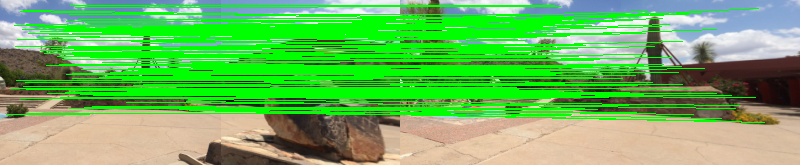

Panaroma


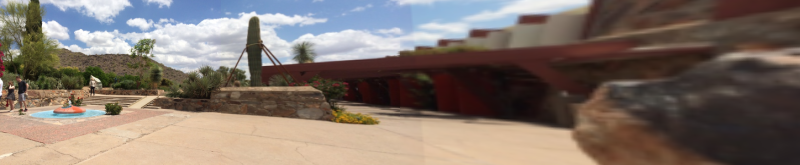

In [50]:
imageA = imutils.resize(images[0], width=400)
imageB = imutils.resize(images[1], width=400)
imageC = imutils.resize(images[2], width=400)

# stitch the images together to create a panorama
stitcher = Stitcher()
intermediateResult1 = stitcher.stitch([imageC, imageB])
intermediateResult2 = stitcher.stitch([imageB, imageA])
imageD = intermediateResult1[0:shape[0], 0:shape[1]-50]
imageE = intermediateResult2[0:shape[0], 0:shape[1]-50]
imageD = imutils.resize(imageD, width=400)
imageE = imutils.resize(imageE, width=400)
(result, vis) = stitcher.stitch([imageD, imageE], showMatches=True)

# show the images
print("Key points")
cv2_imshow(vis)
print("Panaroma")
cv2_imshow(result)